## PG_modeling_LR_SVM_x-validation-bestmodels1990-2016.ipynb

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, multilabel_confusion_matrix
from sklearn.metrics import auc, roc_curve,roc_auc_score, recall_score, precision_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, label_binarize

In [2]:
import pandas as pd  # provides interface for interacting with tabular data
import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join
import os
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import sys
import sklearn
from shapely.ops import nearest_points
from datetime import datetime as dt, date
sys.path.append('/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/code/functions')
from gis_processing import *
from modeling_functions import *
import pickle

## Data Import
### county grid

In [3]:
project_dir = '/Users/pedrogalarza/Documents/NYU-MSDS/2020_fall/DSGA-1001/Project-Wildfire/wildfires-1001/'
data_dir = os.path.join(project_dir, "data")

### Target/Feature DF

In [4]:
weather_rename_dict = pd.read_pickle(os.path.join(data_dir, 'clean_data/ERA_weather-data/ERA_rename_dictionary.pkl'))


target_df1 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_1.pkl'))
target_df2 = pd.read_pickle(os.path.join(data_dir, 'clean_data/target_df_final_1123_newtargets_2.pkl'))
target_df = target_df1.append(target_df2)
target_df.rename(columns = weather_rename_dict, inplace = True)
target_df

,GRID_ID,month_id,MONTH,COUNTYFP,NAME,GRID_AREA,Y_bin,Y_fire_count,Fire_area,elev_mean,...,tot_prcp_12hrs_10y,tot_prcp_18hrs_10y,Y_bin_new_fire_month,Y_count_new_fires_month,Y_max_new_fire_size_month,YEAR,Y_fire_class_size,geometry,Y_fire_area_prop,month_id_old
0,0,1990_10,10,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.001730,0.002638,0,5,0,1990,0,None,0.0,1990_9
1,0,1990_11,11,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.005466,0.007901,0,3,0,1990,0,None,0.0,1990_10
2,0,1990_12,12,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004499,0.007008,0,2,0,1990,0,None,0.0,1990_11
3,0,1990_2,2,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004638,0.006698,0,0,0,1990,0,None,0.0,1990_1
4,0,1990_3,3,15,Del Norte,2.665977e+09,0,0,0.0,36.480644,...,0.004855,0.006756,0,2,0,1990,0,None,0.0,1990_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,147,2019_5,5,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000013,0.000022,0,0,0,2019,0,None,0.0,2019_4
47384,147,2019_6,6,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000001,0.000003,0,0,0,2019,0,None,0.0,2019_5
47385,147,2019_7,7,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000112,0.000154,0,0,0,2019,0,None,0.0,2019_6
47386,147,2019_8,8,71,San Bernardino,5.041000e+09,0,0,0.0,10172.821400,...,0.000093,0.000185,0,0,0,2019,0,None,0.0,2019_7


#### Feature Lists

In [8]:
RF_entropy_top30_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_entropy_top30_features.pkl'))
RF_gini_top20_features = pd.read_pickle(os.path.join(project_dir, 'models/feature_lists/RF_gini_top20_features.pkl'))

In [9]:
non_mod_cols = ['GRID_ID','month_id','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count']
Y_cols = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']
        
target_df_working = target_df

In [10]:
non_mod_cols_PCA = ['GRID_ID','month_id','MONTH','COUNTYFP','COUNTY_AREA', 'NAME','GRID_AREA','COUNTY_ARE','month_id_old_x','month_id_old_y',
                'geometry','Fire_area','total_fire_days','hist_p_time_1y','total_fire_days','hist_p_time_1y', 
                'hist_p_time_1m', 'month_id_old', 'YEAR', 'adj_fire_count', 'adj_fire_bcount']
Y_cols_PCA = ['Y_bin', 'Y_fire_count', 'Y_fire_area_prop', 'Y_fire_class_size','Y_bin_new_fire_month',
          'Y_max_new_fire_size_month','Y_count_new_fires_month']

## Train- test Split

#### select feature and normalize (RF Feature List)

In [11]:
target_model_df=target_df
target_feat = "Y_bin_new_fire_month"
feature_filter = RF_entropy_top30_features

target_model_df[feature_filter] = pd.DataFrame(scale(target_model_df[feature_filter]), columns = feature_filter)
full_time_series_df = target_model_df[["YEAR"] + ["MONTH"] + [target_feat] + feature_filter]
full_time_series_df

,YEAR,MONTH,Y_bin_new_fire_month,2m_tmp_18hrs_10y,hist_fire_area_prop_1y,adj_fire_bcount,hist_fire_area_prop_10y,adj_fire_count,tot_prcp_18hrs_10y,hist_cl_size_1y,...,hist_bin_no_leak_1m,leaf_high_veg_12hrs_5y,hist_bin_10y,leaf_high_veg_0hrs_5y,Unemployment,leaf_high_veg_18hrs_5y,leaf_low_veg_12hrs,elev_range,AGE65PLUS_TOT,MEDIAN_AGE_MALE
0,1990,10,0,-0.197753,-0.208531,-0.611965,-0.514184,-0.41537,1.003192,-0.800661,...,-0.309643,1.732461,-1.905848,1.732461,0.421163,1.732461,-1.486112,-0.485826,-0.440485,0.006359
1,1990,11,0,-0.945186,-0.208531,-0.611965,-0.514184,-0.41537,4.670972,-0.800661,...,-0.309643,1.217454,-1.905848,1.217454,0.421163,1.217454,-1.487025,-0.485826,-0.440485,0.006359
2,1990,12,0,-1.235972,-0.208531,-0.611965,-0.514184,-0.41537,4.048164,-0.800661,...,-0.309643,0.746306,-1.905848,0.746306,0.421163,0.746306,-1.487792,-0.485826,-0.440485,0.006359
3,1990,2,0,-1.102137,-0.208531,-0.611965,-0.514184,-0.41537,3.832015,-0.800661,...,-0.309643,1.098339,-1.905848,1.098339,0.421163,1.098339,-1.488665,-0.485826,-0.440485,0.006359
4,1990,3,0,-0.913141,-0.208531,-0.611965,-0.514184,-0.41537,3.872706,-0.800661,...,-0.309643,1.114874,-1.905848,1.114874,0.421163,1.114874,-1.487873,-0.485826,-0.440485,0.006359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47383,2019,5,0,1.267332,-0.208531,-0.611965,-0.514184,-0.41537,-0.819744,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-2.143862,-1.888961,-1.152042,-0.618477,-0.302000,-0.774800
47384,2019,6,0,1.982330,-0.208531,-0.611965,-0.514184,-0.41537,-0.833419,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-2.143862,-1.888961,-1.152042,-0.618477,-0.302000,-0.774800
47385,2019,7,0,2.270351,-0.208531,-0.611965,-0.514184,-0.41537,-0.728202,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-2.143862,-1.888961,-1.152060,-0.618477,-0.302000,-0.774800
47386,2019,8,0,2.181627,-0.208531,-0.611965,-0.514184,-0.41537,-0.706092,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-2.143862,-1.888961,-1.152687,-0.618477,-0.302000,-0.774800


#### Split data into train and test sets (RF Reature List)

In [12]:
train_data = full_time_series_df[(target_model_df['YEAR']>=1990) & (target_model_df['YEAR']<=2016)]
test_data = full_time_series_df[target_model_df['YEAR']>2016]
train_data

,YEAR,MONTH,Y_bin_new_fire_month,2m_tmp_18hrs_10y,hist_fire_area_prop_1y,adj_fire_bcount,hist_fire_area_prop_10y,adj_fire_count,tot_prcp_18hrs_10y,hist_cl_size_1y,...,hist_bin_no_leak_1m,leaf_high_veg_12hrs_5y,hist_bin_10y,leaf_high_veg_0hrs_5y,Unemployment,leaf_high_veg_18hrs_5y,leaf_low_veg_12hrs,elev_range,AGE65PLUS_TOT,MEDIAN_AGE_MALE
0,1990,10,0,-0.197753,-0.208531,-0.611965,-0.514184,-0.41537,1.003192,-0.800661,...,-0.309643,1.732461,-1.905848,1.732461,0.421163,1.732461,-1.486112,-0.485826,-0.440485,0.006359
1,1990,11,0,-0.945186,-0.208531,-0.611965,-0.514184,-0.41537,4.670972,-0.800661,...,-0.309643,1.217454,-1.905848,1.217454,0.421163,1.217454,-1.487025,-0.485826,-0.440485,0.006359
2,1990,12,0,-1.235972,-0.208531,-0.611965,-0.514184,-0.41537,4.048164,-0.800661,...,-0.309643,0.746306,-1.905848,0.746306,0.421163,0.746306,-1.487792,-0.485826,-0.440485,0.006359
3,1990,2,0,-1.102137,-0.208531,-0.611965,-0.514184,-0.41537,3.832015,-0.800661,...,-0.309643,1.098339,-1.905848,1.098339,0.421163,1.098339,-1.488665,-0.485826,-0.440485,0.006359
4,1990,3,0,-0.913141,-0.208531,-0.611965,-0.514184,-0.41537,3.872706,-0.800661,...,-0.309643,1.114874,-1.905848,1.114874,0.421163,1.114874,-1.487873,-0.485826,-0.440485,0.006359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47347,2016,5,0,1.306226,-0.208531,-0.611965,-0.514184,-0.41537,-0.825580,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-1.502605,-1.888961,-1.152042,-0.618477,-0.320028,-0.888719
47348,2016,6,0,1.966889,-0.208531,-0.611965,-0.514184,-0.41537,-0.831925,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-1.502605,-1.888961,-1.152042,-0.618477,-0.320028,-0.888719
47349,2016,7,0,2.261950,-0.208531,-0.611965,-0.514184,-0.41537,-0.766944,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-1.502605,-1.888961,-1.152060,-0.618477,-0.320028,-0.888719
47350,2016,8,0,2.166448,-0.208531,-0.611965,-0.514184,-0.41537,-0.719367,-0.800661,...,-0.309643,-1.888961,-1.905848,-1.888961,-1.502605,-1.888961,-1.152687,-0.618477,-0.320028,-0.888719


#### Build Cross Validation Splits: LR, Rolling Origin

In [13]:
def xVal_time_series_rolling_LR(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}
    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            LR_ts_kfold = LogisticRegression(C = c, class_weight = 'balanced').fit(train_fold.drop(label_name, 1),train_fold[label_name])
            
            LR_ts_y_bin = np.array(validation_fold[label_name])
            LR_ts_preds = LR_ts_kfold.predict(validation_fold.drop(label_name,1))
            LR_ts_proba = LR_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1]

            AUC_search = roc_auc_score(LR_ts_y_bin, LR_ts_proba)
            recall_search = recall_score(LR_ts_y_bin, LR_ts_preds)
            EV_search = EV_binary(LR_ts_y_bin, LR_ts_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)

            
            if c in AUC_dict:
                AUC_dict[c].append(AUC_search)
            else:
                AUC_dict[c] = [AUC_search]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in EV_dict:
                EV_dict[c].append(EV_search)
            else:
                EV_dict[c] = [EV_search]            
        
    return({"AUC":pd.DataFrame(AUC_dict),"Recall":pd.DataFrame(recall_dict),"EV":pd.DataFrame(EV_dict)})

#### Build Cross Validation Splits: LR, Sliding Window

In [14]:
def xVal_time_series_sliding_LR(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}
    
    for i in range(1,k):
        train_fold = dataset[dataset["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = dataset[dataset["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            LR_ts_kfold = LogisticRegression(C = c, class_weight = 'balanced').fit(train_fold.drop(label_name, 1),train_fold[label_name])
            
            LR_ts_y_bin = np.array(validation_fold[label_name])
            LR_ts_preds = LR_ts_kfold.predict(validation_fold.drop(label_name,1))
            LR_ts_proba = LR_ts_kfold.predict_proba(validation_fold.drop(label_name,1))[:,1]

            AUC_search = roc_auc_score(LR_ts_y_bin, LR_ts_proba)
            recall_search = recall_score(LR_ts_y_bin, LR_ts_preds)
            EV_search = EV_binary(LR_ts_y_bin, LR_ts_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)

            
            if c in AUC_dict:
                AUC_dict[c].append(AUC_search)
            else:
                AUC_dict[c] = [AUC_search]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in EV_dict:
                EV_dict[c].append(EV_search)
            else:
                EV_dict[c] = [EV_search]            
        
    return({"AUC":pd.DataFrame(AUC_dict),"Recall":pd.DataFrame(recall_dict),"EV":pd.DataFrame(EV_dict)})

#### Cross Validation Comparison (LR, RF)

In [15]:
cs = [10**i for i in range(-8, 2)]
rolling_xVal_LR = xVal_time_series_rolling_LR(train_data, "Y_bin_new_fire_month",9,cs)
sliding_xVal_LR = xVal_time_series_sliding_LR(train_data, "Y_bin_new_fire_month",9,cs)

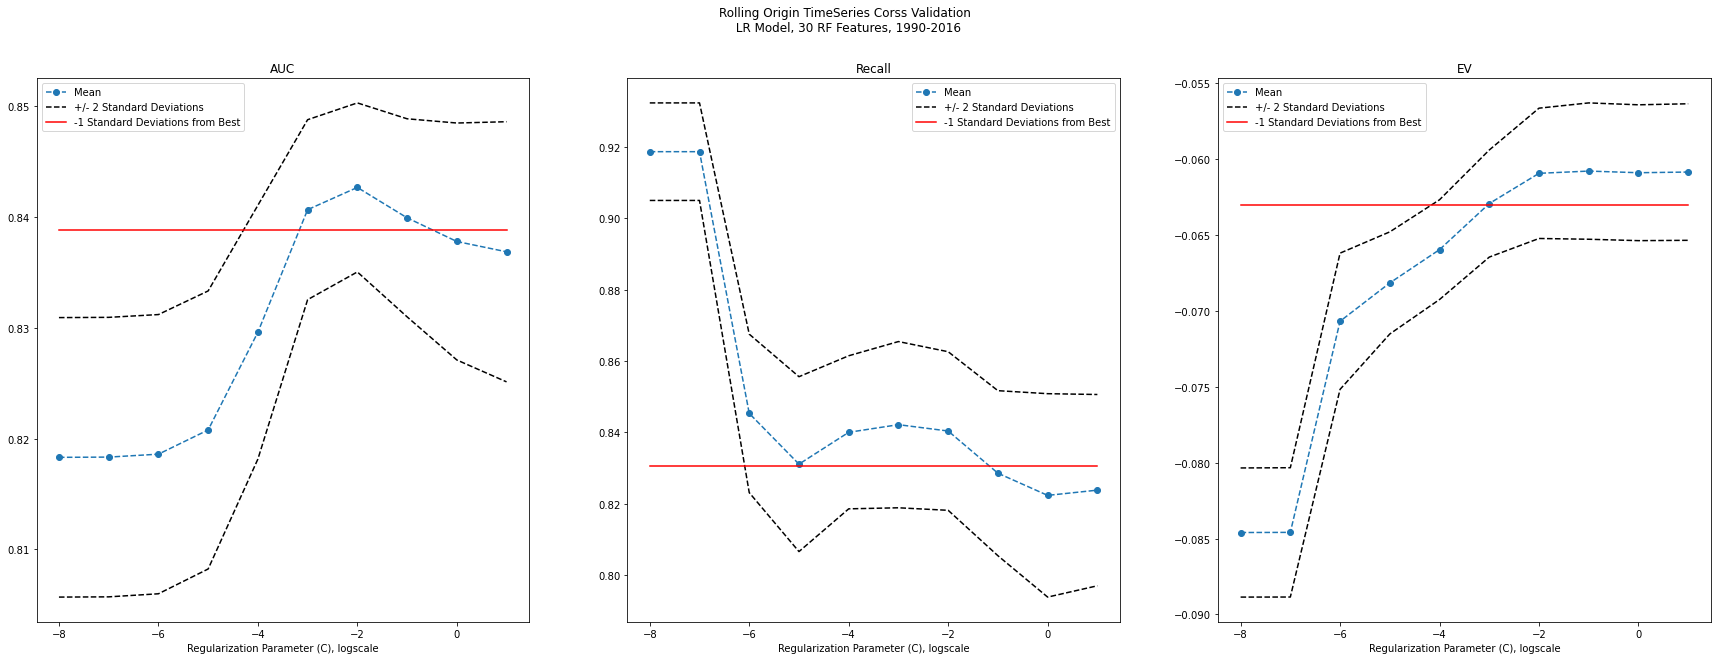

In [134]:
fig,ax = plt.subplots(1,3, figsize = (30,10))
for i,j in enumerate(rolling_xVal_LR):
    ax[i].plot(range(-8, 2),rolling_xVal_LR[j].mean(),"o--", label="Mean")
    ax[i].plot(range(-8, 2),rolling_xVal_LR[j].mean()- 2*rolling_xVal_LR[j].std()/np.sqrt(10),"k--", label = "+/- 2 Standard Deviations")
    ax[i].plot(range(-8, 2),rolling_xVal_LR[j].mean() + 2*rolling_xVal_LR[j].std()/np.sqrt(10),"k--")

    index_drops = []
    for index,value in enumerate(rolling_xVal_LR[j].mean().iloc[:-1]):
        if value >= rolling_xVal_LR[j].mean().iloc[index+1]:
            index_drops.append(rolling_xVal_LR[j].mean().index[index+1])

    filtered_means = rolling_xVal_LR[j].mean().drop(labels = index_drops).iloc[1:]
            
            
    ax[i].plot(range(-8, 2),[np.max(filtered_means)-rolling_xVal_LR[j].std().loc[filtered_means.idxmax()]/np.sqrt(10)]*10,"r", label = "-1 Standard Deviations from Best")    
    
    ax[i].set_xlabel("Regularization Parameter (C), logscale")
    ax[i].legend()
    ax[i].set_title(j)
fig.suptitle("Rolling Origin TimeSeries Corss Validation \n LR Model, 30 RF Features, 1990-2016")
plt.show()

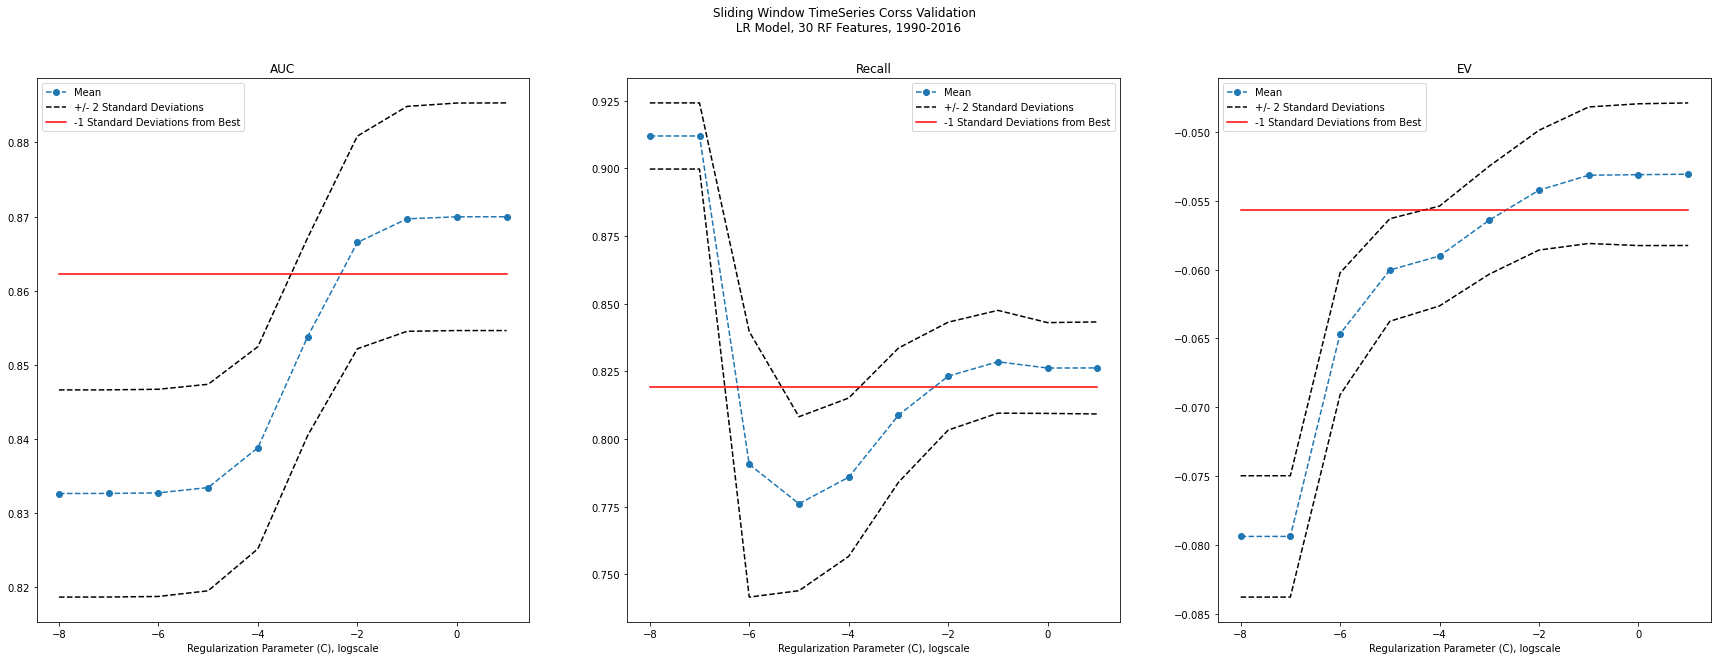

In [135]:
fig,ax = plt.subplots(1,3, figsize = (30,10))
for i,j in enumerate(sliding_xVal_LR):
    ax[i].plot(range(-8, 2),sliding_xVal_LR[j].mean(),"o--", label = "Mean")
    ax[i].plot(range(-8, 2),sliding_xVal_LR[j].mean()- 2*sliding_xVal_LR[j].std()/np.sqrt(10),"k--",label = "+/- 2 Standard Deviations")
    ax[i].plot(range(-8, 2),sliding_xVal_LR[j].mean() + 2*sliding_xVal_LR[j].std()/np.sqrt(10),"k--")
    
    index_drops = []
    for index,value in enumerate(sliding_xVal_LR[j].mean().iloc[:-1]):
        if value >= sliding_xVal_LR[j].mean().iloc[index+1]:
            index_drops.append(sliding_xVal_LR[j].mean().index[index+1])

    filtered_means = sliding_xVal_LR[j].mean().drop(labels = index_drops).iloc[1:]
            
            
    ax[i].plot(range(-8, 2),[np.max(filtered_means)-sliding_xVal_LR[j].std().loc[filtered_means.idxmax()]/np.sqrt(10)]*10,"r",label = "-1 Standard Deviations from Best")
    ax[i].set_xlabel("Regularization Parameter (C), logscale")
    ax[i].legend()
    ax[i].set_title(j)
fig.suptitle("Sliding Window TimeSeries Corss Validation \n LR Model, 30 RF Features, 1990-2016")
plt.show()

### SVM

In [25]:
def xVal_time_series_rolling_SVM(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}

    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[:i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        
        for c in cs:
            model_ts_kfold = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(train_fold.drop(label_name, 1),train_fold[label_name])
            SVM_ts_y_bin = np.array(validation_fold[label_name])
            linSVC_score = model_ts_kfold.decision_function(validation_fold.drop(label_name, 1))
            linSVC_preds = model_ts_kfold.predict(validation_fold.drop(label_name, 1))
            
            
            recall_search = recall_score(validation_fold[label_name], linSVC_preds)
            precision_search = precision_score(validation_fold[label_name], linSVC_preds)
            fpr, tpr, thresholds = roc_curve(validation_fold[label_name], linSVC_score)
            EV_search = EV_binary(SVM_ts_y_bin, linSVC_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)


            
            if c in AUC_dict:
                AUC_dict[c].append(auc(fpr, tpr))
            else:
                AUC_dict[c] = [auc(fpr, tpr)]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in EV_dict:
                EV_dict[c].append(EV_search)
            else:
                EV_dict[c] = [EV_search]
            
    return({"AUC":pd.DataFrame(AUC_dict),"Recall":pd.DataFrame(recall_dict),"EV":pd.DataFrame(EV_dict)})

In [26]:
def xVal_time_series_sliding_SVM(dataset, label_name,k,cs):
    years_unique = dataset.YEAR.unique()
    years_len = len(years_unique)
    interval_len = int(years_len/k)
    
    k_fold_list = []
    for i in range(years_len):
        k_fold_list.append(years_unique[interval_len*i:interval_len*i+interval_len])
        k_fold_list = k_fold_list[:k]
        
        
    AUC_dict = {}
    recall_dict = {}
    EV_dict = {}

    
    for i in range(1,k):
        train_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        validation_fold = train_data[train_data["YEAR"].isin(np.ravel(k_fold_list[i]))].drop(["YEAR","MONTH"],axis=1)
        
        for c in cs:
            model_ts_kfold = LinearSVC(C = c, class_weight = 'balanced', dual = False).fit(train_fold.drop(label_name, 1),train_fold[label_name])
            SVM_ts_y_bin = np.array(validation_fold[label_name])
            linSVC_score = model_ts_kfold.decision_function(validation_fold.drop(label_name, 1))
            linSVC_preds = model_ts_kfold.predict(validation_fold.drop(label_name, 1))
            
            
            recall_search = recall_score(validation_fold[label_name], linSVC_preds)
            precision_search = precision_score(validation_fold[label_name], linSVC_preds)
            fpr, tpr, thresholds = roc_curve(validation_fold[label_name], linSVC_score)
            EV_search = EV_binary(SVM_ts_y_bin, linSVC_preds, V_tp = 0, V_tn = 0, C_fp = -0.1875, C_fn = -0.75)


            
            if c in AUC_dict:
                AUC_dict[c].append(auc(fpr, tpr))
            else:
                AUC_dict[c] = [auc(fpr, tpr)]
            if c in recall_dict:
                recall_dict[c].append(recall_search)
            else:
                recall_dict[c] = [recall_search]
            if c in EV_dict:
                EV_dict[c].append(EV_search)
            else:
                EV_dict[c] = [EV_search]
            
    return({"AUC":pd.DataFrame(AUC_dict),"Recall":pd.DataFrame(recall_dict),"EV":pd.DataFrame(EV_dict)})

In [27]:
cs = [10**i for i in range(-8, 2)]
rolling_xVal_SVM = xVal_time_series_rolling_SVM(train_data, "Y_bin_new_fire_month",9,cs)
sliding_xVal_SVM = xVal_time_series_sliding_SVM(train_data, "Y_bin_new_fire_month",9,cs)

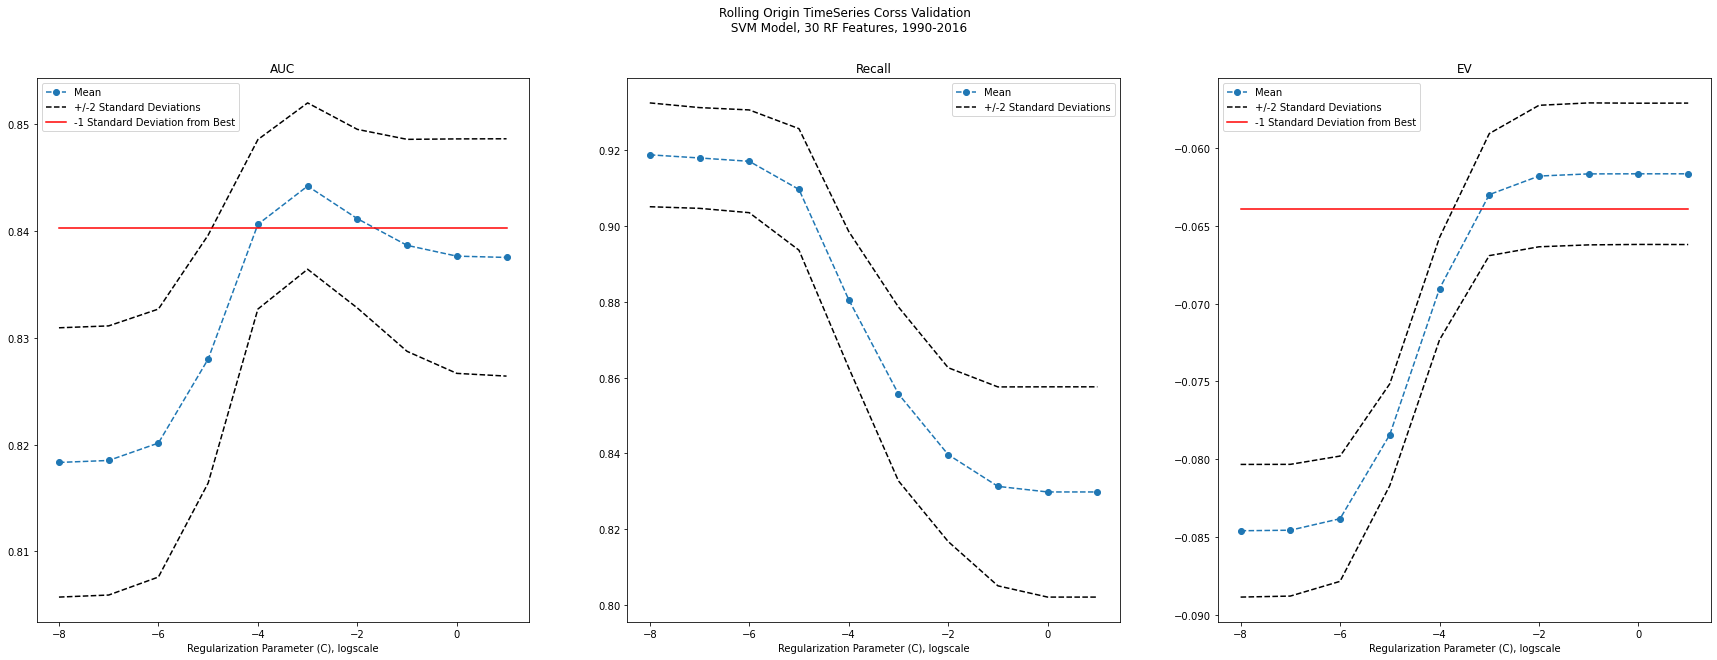

In [136]:
fig,ax = plt.subplots(1,3, figsize = (30,10))
for i,j in enumerate(rolling_xVal_SVM):
    ax[i].plot(range(-8, 2),rolling_xVal_SVM[j].mean(),"o--",label="Mean")
    ax[i].plot(range(-8, 2),rolling_xVal_SVM[j].mean()- 2*rolling_xVal_SVM[j].std()/np.sqrt(10),"k--",label = "+/-2 Standard Deviations")
    ax[i].plot(range(-8, 2),rolling_xVal_SVM[j].mean() + 2*rolling_xVal_SVM[j].std()/np.sqrt(10),"k--")
    index_drops = []
    for index,value in enumerate(rolling_xVal_SVM[j].mean().iloc[:-1]):
        if value >= rolling_xVal_SVM[j].mean().iloc[index+1]:
            index_drops.append(rolling_xVal_SVM[j].mean().index[index+1])    
    if len(index_drops)<9:
        filtered_means = rolling_xVal_SVM[j].mean().drop(labels = index_drops).iloc[1:]
        ax[i].plot(range(-8, 2),[np.max(filtered_means)-rolling_xVal_SVM[j].std().loc[filtered_means.idxmax()]/np.sqrt(10)]*10,"r",label = "-1 Standard Deviation from Best")
    
    
    ax[i].set_xlabel("Regularization Parameter (C), logscale")
    ax[i].set_title(j)
    ax[i].legend()
fig.suptitle("Rolling Origin TimeSeries Corss Validation \n SVM Model, 30 RF Features, 1990-2016")
plt.show()

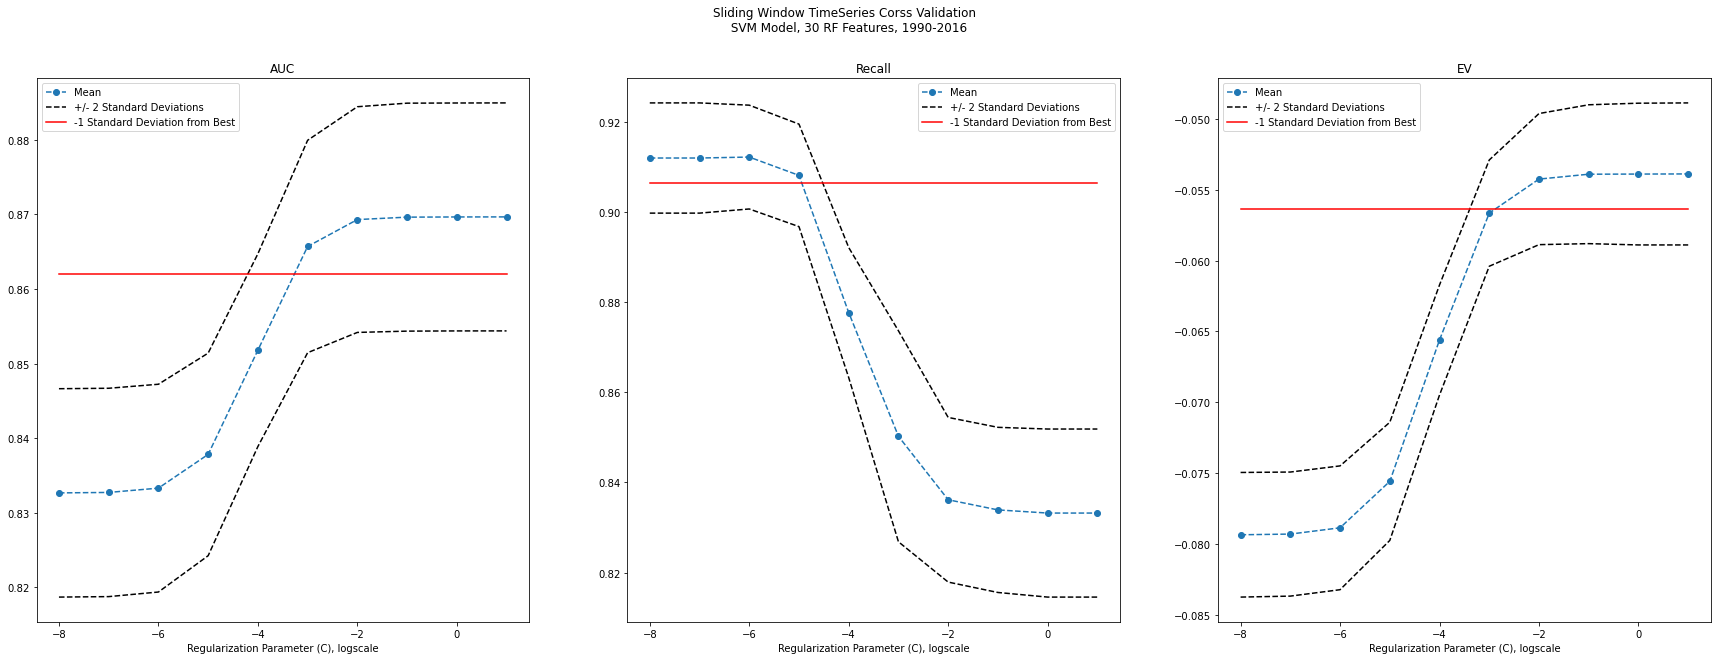

In [137]:
fig,ax = plt.subplots(1,3, figsize = (30,10))
for i,j in enumerate(sliding_xVal_SVM):
    ax[i].plot(range(-8, 2),sliding_xVal_SVM[j].mean(),"o--", label = "Mean")
    ax[i].plot(range(-8, 2),sliding_xVal_SVM[j].mean()- 2*sliding_xVal_SVM[j].std()/np.sqrt(10),"k--", label="+/- 2 Standard Deviations")
    ax[i].plot(range(-8, 2),sliding_xVal_SVM[j].mean() + 2*sliding_xVal_SVM[j].std()/np.sqrt(10),"k--")
    index_drops = []
    for index,value in enumerate(sliding_xVal_SVM[j].mean().iloc[:-1]):
        if value >= sliding_xVal_SVM[j].mean().iloc[index+1]:
            index_drops.append(sliding_xVal_SVM[j].mean().index[index+1])    
    if len(index_drops)<9:
        filtered_means = sliding_xVal_SVM[j].mean().drop(labels = index_drops).iloc[1:]
        ax[i].plot(range(-8, 2),[np.max(filtered_means)-sliding_xVal_SVM[j].std().loc[filtered_means.idxmax()]/np.sqrt(10)]*10,"r",label = "-1 Standard Deviation from Best")
    
    ax[i].set_xlabel("Regularization Parameter (C), logscale")
    ax[i].set_title(j)
    ax[i].legend()
fig.suptitle("Sliding Window TimeSeries Corss Validation \n SVM Model, 30 RF Features, 1990-2016")
plt.show()